In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [10]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                
                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector
                                

            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
            
            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 86.20%
Success Probability Vector:
tensor([9.7900e-01, 7.6030e-04, 5.7726e-03, 9.0958e-04, 1.9217e-03, 4.4852e-04,
        7.8176e-04, 3.0910e-04, 5.5733e-03, 4.5287e-03], device='cuda:0')
Class 2 - Accuracy: 91.90%
Success Probability Vector:
tensor([9.0179e-04, 9.8638e-01, 2.7852e-04, 3.2315e-04, 1.7752e-04, 2.7641e-04,
        6.5667e-04, 2.7009e-04, 1.9003e-03, 8.8335e-03], device='cuda:0')
Class 3 - Accuracy: 78.80%
Success Probability Vector:
tensor([7.1315e-03, 4.6578e-04, 9.6990e-01, 5.7796e-03, 5.5900e-03, 3.3257e-03,
        4.2539e-03, 1.5288e-03, 1.1381e-03, 8.8660e-04], device='cuda:0')
Class 4 - Accuracy: 65.20%
Success Probability Vector:
tensor([0.0021, 0.0014, 0.0122, 0.9388, 0.0070, 0.0263, 0.0051, 0.0036, 0.0023,
        0.0012], device='cuda:0')
Class 5 - Accuracy: 81.40%
Success Probability Vector:
tensor([1.9248e-03, 3.9627e-04, 7.9150e-03, 6.0867e-03, 9.6665e-01, 5.420

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 1.0, Variance = 1.4565713027465325e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 1 (Failed): Mean = 1.0, Variance = 1.2966108247234524e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 2 (Successful): Mean = 1.0, Variance = 1.4125713292684606e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 2 (Failed): Mean = 1.0, Variance = 1.1546319032585154e-15, Min = 0.9999999403953552, Max = 1.0000001192092896
Class 3 (Successful): Mean = 1.0, Variance = 1.4219883239386787e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 3 (Failed): Mean = 1.0, Variance = 1.4311879487788077e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Successful): Mean = 1.0, Variance = 1.3697866363114619e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 4 (Failed): Mean = 1.0, Variance = 1.37194127637104e-15, Min = 0.9999998807907104, Max = 1.0000001192092896
Class 5 (Successful): Mean = 1.0, Variance = 1.31533438214

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [10]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)
                    
                print(before_acc_results)

                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                    
                    
                    


Files already downloaded and verified
Files already downloaded and verified
[91.0, 85.0, 83.0, 83.0, 92.0, 83.0, 81.0, 84.0, 85.0, 90.0, 83.0, 80.0, 79.0, 82.0, 82.0, 75.0, 83.0, 78.0, 88.0, 86.0, 80.0, 82.0, 82.0, 84.0, 69.0, 83.0, 85.0, 80.0, 85.0, 81.0, 83.0, 74.0, 85.0, 81.0, 82.0, 89.0, 83.0, 89.0, 85.0, 88.0, 89.0, 82.0, 85.0, 78.0, 82.0, 81.0, 85.0, 86.0, 80.0, 84.0, 81.0, 79.0, 83.0, 81.0, 80.0, 86.0, 88.0, 84.0, 87.0, 88.0, 82.0, 84.0, 80.0, 81.0, 82.0, 84.0, 94.0, 85.0, 86.0, 82.0, 77.0, 85.0, 74.0, 79.0, 79.0, 89.0, 85.0, 76.0, 85.0, 82.0, 89.0, 84.0, 84.0, 88.0, 83.0, 87.0, 72.0, 89.0, 87.0, 87.0, 84.0, 88.0, 86.0, 83.0, 78.0, 79.0, 89.0, 81.0, 90.0, 73.0]
Before min/max/mean/std of accuracy
69.0 94.0 83.24 4.37


In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {0: 100, 1: 50, 4: 50, 7: 100, 8: 50, 9: 150}, 1: {1: 50, 2: 100, 4: 100, 5: 50, 7: 50, 9: 150}, 2: {0: 50, 2: 50, 3: 50, 4: 150, 6: 100, 8: 50, 9: 50}, 3: {1: 100, 2: 50, 3: 50, 4: 50, 5: 50, 7: 50, 9: 150}, 4: {0: 100, 1: 50, 4: 50, 6: 100, 8: 150, 9: 50}, 5: {0: 50, 1: 50, 2: 50, 3: 50, 6: 50, 7: 50, 8: 50, 9: 150}, 6: {1: 50, 2: 50, 3: 50, 4: 150, 5: 50, 7: 50, 9: 100}, 7: {0: 100, 2: 50, 3: 100, 5: 50, 6: 50, 8: 100, 9: 50}, 8: {0: 50, 1: 100, 3: 50, 4: 150, 5: 50, 6: 50, 9: 50}, 9: {0: 100, 1: 100, 2: 50, 3: 50, 5: 50, 6: 50, 8: 100}, 10: {1: 50, 3: 50, 4: 50, 5: 150, 7: 100, 8: 50, 9: 50}, 11: {1: 50, 2: 100, 4: 50, 5: 100, 6: 50, 7: 50, 9: 100}, 12: {0: 100, 1: 100, 3: 100, 5: 100, 8: 100}, 13: {0: 50, 3: 50, 4: 50, 5: 200, 9: 150}, 14: {4: 50, 5: 150, 6: 50, 8: 150, 9: 100}, 15: {0: 100, 2: 100, 3: 150, 6: 50, 7: 50, 9: 50}, 16: {0: 50, 1: 50, 2: 50, 4: 150, 7: 100, 8: 100}, 17: {0: 50, 1: 50, 2: 50, 3: 150, 7: 50, 8: 

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {0: 20, 1: 10, 4: 10, 7: 20, 8: 10, 9: 30}, 1: {1: 10, 2: 20, 4: 20, 5: 10, 7: 10, 9: 30}, 2: {0: 10, 2: 10, 3: 10, 4: 30, 6: 20, 8: 10, 9: 10}, 3: {1: 20, 2: 10, 3: 10, 4: 10, 5: 10, 7: 10, 9: 30}, 4: {0: 20, 1: 10, 4: 10, 6: 20, 8: 30, 9: 10}, 5: {0: 10, 1: 10, 2: 10, 3: 10, 6: 10, 7: 10, 8: 10, 9: 30}, 6: {1: 10, 2: 10, 3: 10, 4: 30, 5: 10, 7: 10, 9: 20}, 7: {0: 20, 2: 10, 3: 20, 5: 10, 6: 10, 8: 20, 9: 10}, 8: {0: 10, 1: 20, 3: 10, 4: 30, 5: 10, 6: 10, 9: 10}, 9: {0: 20, 1: 20, 2: 10, 3: 10, 5: 10, 6: 10, 8: 20}, 10: {1: 10, 3: 10, 4: 10, 5: 30, 7: 20, 8: 10, 9: 10}, 11: {1: 10, 2: 20, 4: 10, 5: 20, 6: 10, 7: 10, 9: 20}, 12: {0: 20, 1: 20, 3: 20, 5: 20, 8: 20}, 13: {0: 10, 3: 10, 4: 10, 5: 40, 9: 30}, 14: {4: 10, 5: 30, 6: 10, 8: 30, 9: 20}, 15: {0: 20, 2: 20, 3: 30, 6: 10, 7: 10, 9: 10}, 16: {0: 10, 1: 10, 2: 10, 4: 30, 7: 20, 8: 20}, 17: {0: 10, 1: 10, 2: 10, 3: 30, 7: 10, 8: 20, 9: 10}, 18: {0: 10, 1: 10, 2: 10, 3: 10, 4:

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([ 0.0570, -0.0235, -0.0679,  0.0069, -0.0265,  0.0296, -0.0087, -0.0591,
         0.0546,  0.0567], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([68.3972, 73.0973, 67.6061, 65.9526, 69.7797, 68.9111, 72.5299, 71.2171,
        72.2030, 70.8172], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000, -0.0701, -0.0387, -0.1653, -0.1364, -0.2248, -0.2221, -0.1960,
          0.0939, -0.0369],
        [-0.0701,  1.0000, -0.2121, -0.2077, -0.1898, -0.1718, -0.1402, -0.1701,
          0.0136,  0.1168],
        [-0.0387, -0.2121,  1.0000, -0.0648, -0.0343, -0.1117, -0.0230, -0.1109,
         -0.1482, -0.2134],
        [-0.1653, -0.2077, -0.0648,  1.0000, -0.1339,  0.0904, -0.0364, -0.0930,
         -0.1567, -0.1933],
        [-0.1364, -0.1898, -0.0343, -0.1339,  1.0000, -0.0561, -0.0223,  0.0193,
         -0.1979, -0.2

Weight norm of each class part of classifier
tensor([8.2703, 8.5497, 8.2223, 8.1211, 8.3534, 8.3013, 8.5164, 8.4390, 8.4972,
        8.4153], device='cuda:0', grad_fn=<SqrtBackward0>)


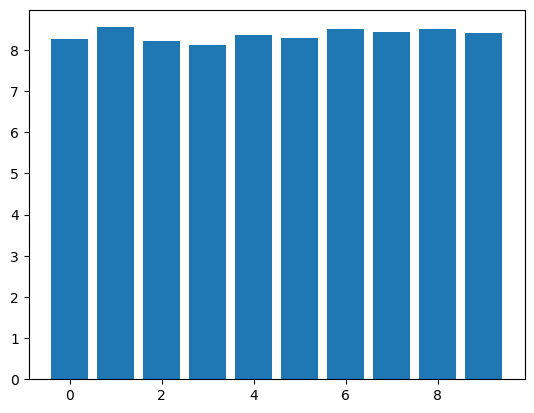

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

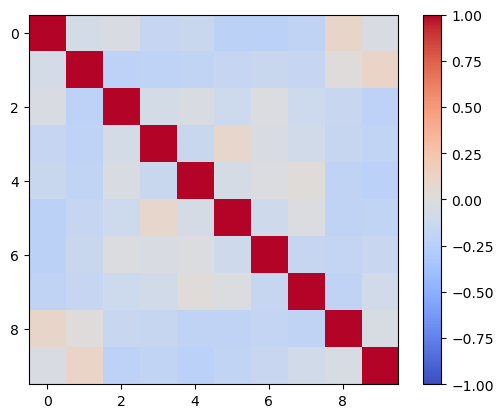

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.89269495, 1: 0.93951386, 2: 0.84398764, 3: 0.78346545, 4: 0.8649169, 5: 0.83556175, 6: 0.90925014, 7: 0.8973548, 8: 0.93036133, 9: 0.91722083}
-------------------VAR-------------------
{0: 0.046132136, 1: 0.027345372, 2: 0.05592511, 3: 0.051873505, 4: 0.044906203, 5: 0.0462476, 6: 0.03549573, 7: 0.04258335, 8: 0.03221315, 9: 0.036636}


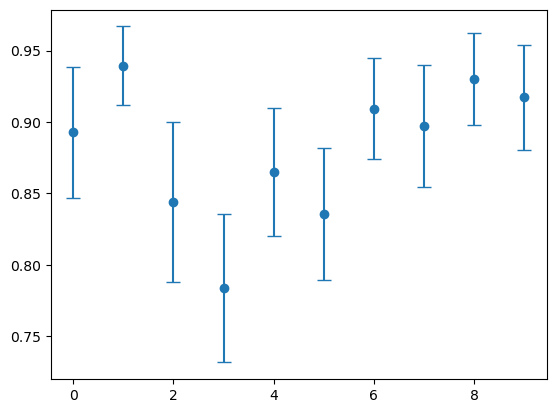

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [10]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]                    


                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]

                print(class_mean_dict)
                #Get a Inner product of each class's centroid vector

                sorted_keys=sorted(class_mean_dict)
                print(sorted_keys)

                class_mean_lst=[]


                for key in sorted_keys:
                    class_mean_lst.append(class_mean_dict[key])

                class_mean_lst=torch.stack(class_mean_lst)


                print(class_mean_lst.shape)
                print(class_mean_lst.transpose(0,1).shape)

                #Get the each centroid vector's norm
                print("-------------Norm of each centroid vectors --------------")
                print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


                #Get the cosine similarity result between eacn centroid vectors


                normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
                print("-------------Cosine similarity of Each Centroid vectors--------------")
                print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())
                    
                    
    


Files already downloaded and verified
Files already downloaded and verified
{0: tensor([7.7747e-02, 6.9390e-03, 0.0000e+00, 1.8007e-03, 3.9252e-03, 1.3177e-07,
        2.6240e-02, 5.8055e-03, 7.6848e-02, 2.0656e-05, 1.0988e-03, 5.2921e-03,
        2.0801e-02, 6.3955e-03, 1.8584e-03, 5.0732e-03, 6.7542e-02, 6.5586e-02,
        2.5476e-03, 1.0501e-03, 2.3572e-03, 1.2012e-02, 4.1813e-03, 2.7090e-03,
        1.3840e-02, 1.8618e-03, 8.1311e-03, 1.4774e-02, 4.8921e-03, 4.2864e-06,
        3.0508e-03, 7.8267e-04, 1.5088e-02, 4.1725e-03, 4.3962e-03, 5.5188e-06,
        6.0634e-04, 8.1235e-05, 9.4681e-05, 8.2617e-03, 1.6372e-01, 0.0000e+00,
        5.2455e-03, 4.1949e-03, 8.1880e-03, 7.5028e-02, 9.7492e-04, 6.4236e-03,
        1.8166e-03, 4.7535e-03, 3.7510e-04, 2.0784e-03, 6.7753e-03, 1.3587e-02,
        5.4537e-02, 3.1812e-03, 4.1253e-03, 1.5171e-02, 2.2406e-02, 4.5813e-03,
        6.3095e-02, 3.7712e-03, 4.8362e-03, 5.1962e-04, 5.2099e-03, 1.8199e-02,
        3.5103e-03, 3.2477e-03, 6.6777e-

# Cosine Similarity of Centroid Vectors

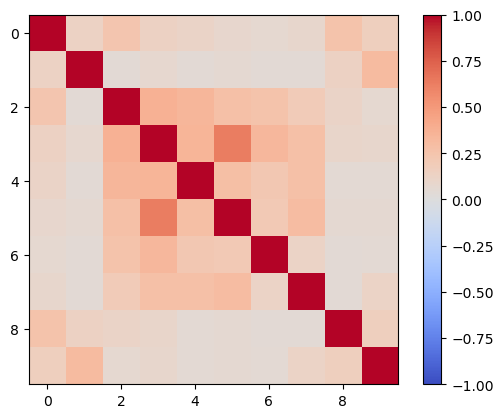

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[0.99999994 0.12995368 0.23707545 0.13628188 0.11431523 0.08514124
  0.07016566 0.09193113 0.25461686 0.16246593]
 [0.12995368 1.         0.04066192 0.07033004 0.0428091  0.05866516
  0.04666881 0.04630617 0.13827805 0.30757326]
 [0.23707545 0.04066192 0.9999998  0.368909   0.34051758 0.27454323
  0.25762513 0.19286281 0.11094198 0.06658796]
 [0.13628188 0.07033004 0.368909   1.0000001  0.34442383 0.63155246
  0.32940802 0.2764914  0.0998088  0.08856377]
 [0.11431523 0.0428091  0.34051758 0.34442383 0.99999994 0.2865538
  0.22552346 0.27744412 0.05181234 0.04908076]
 [0.08514124 0.05866516 0.27454323 0.63155246 0.2865538  1.0000001
  0.20980617 0.29710513 0.05794321 0.06220107]
 [0.07016566 0.04666881 0.25762513 0.32940802 0.22552346 0.20980617
  0.9999999  0.11981562 0.04208456 0.05102225]
 [0.09193113 0.04630617 0.19286281 0.2764914  0.27744412 0.29710513
  0.11981562 0.9999999  0.04389732 0.12173471]
 [0.25461686 0.13827805 0.11094198 0.0998088  0.05181234 0

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.8586, 0.8638, 0.8398, 0.7733, 0.8287, 0.7979, 0.8454, 0.8460, 0.8634,
        0.8626], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.8586, 0.8638, 0.8398, 0.7733, 0.8287, 0.7979, 0.8454, 0.8460, 0.8634,
        0.8626], device='cuda:0', grad_fn=<DiagonalBackward0>)


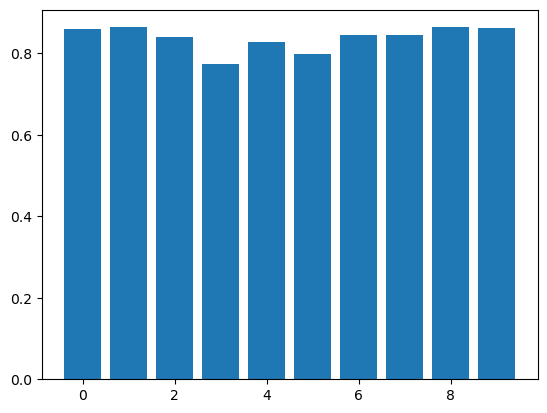

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()